In [1]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

#### Load an example image and text

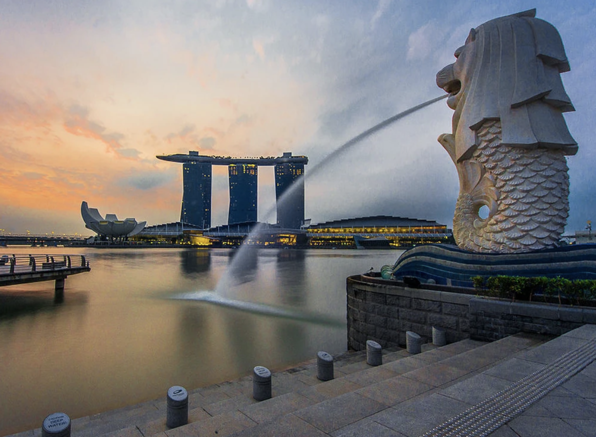

In [2]:
raw_image = Image.open("../docs/_static/merlion.png").convert("RGB")
display(raw_image.resize((596, 437)))

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
caption = "Merlion near marina bay."

#### Load model and preprocessors

In [5]:
# model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "base", device=device, is_eval=True)
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)

#### Plot utilities for GradCam

In [6]:
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np

dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

#### Preprocess image and text inputs

In [7]:
img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)

#### Compute GradCam

In [8]:
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)

#### Average GradCam for the full image

In [9]:
avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)

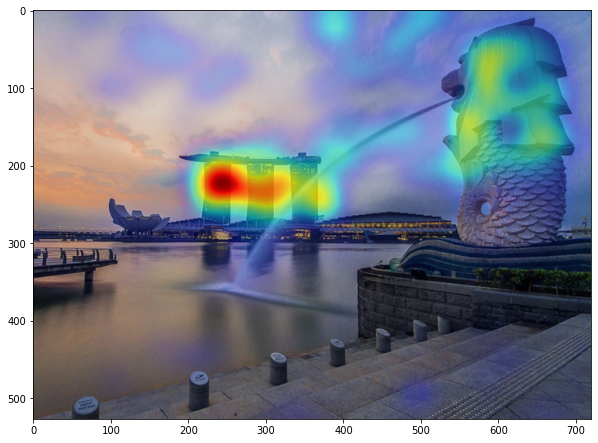

In [10]:
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_gradcam)


#### GradCam for each token

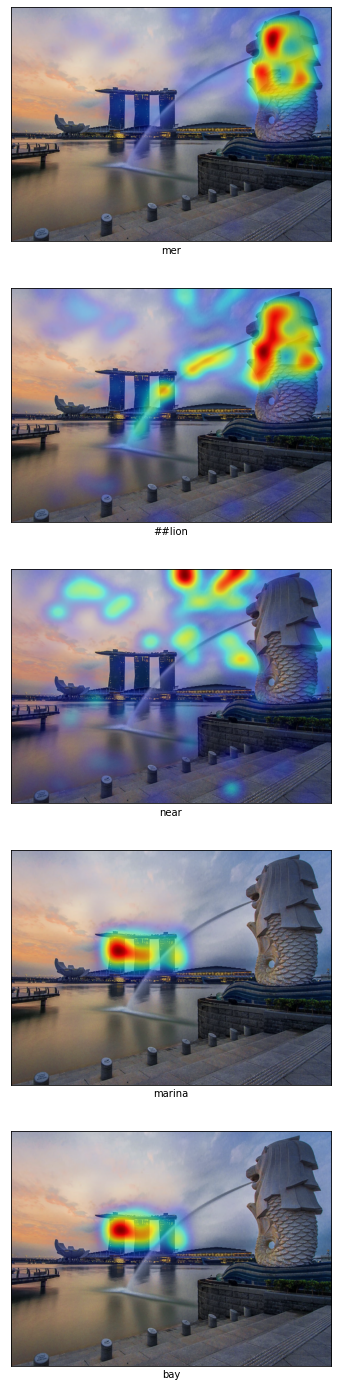

In [11]:
num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(norm_img, gradcam, blur=True)
    ax[i].imshow(gradcam_image)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(word)
    